In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
%matplotlib inline
import glob

In [2]:
print("Tensorflow version: {}".format(tf.__version__))

Tensorflow version: 2.10.0


In [3]:
os.listdir("./dataset/image_position_dataset/annotations/trimaps")[-5:]

['yorkshire_terrier_95.png',
 'yorkshire_terrier_96.png',
 'yorkshire_terrier_97.png',
 'yorkshire_terrier_98.png',
 'yorkshire_terrier_99.png']

In [4]:
image = tf.io.read_file("./dataset/image_position_dataset/annotations/trimaps/yorkshire_terrier_99.png")

In [5]:
image = tf.image.decode_jpeg(image)

In [6]:
image.shape

TensorShape([358, 500, 1])

In [7]:
image = tf.squeeze(image)

In [8]:
image.shape

TensorShape([358, 500])

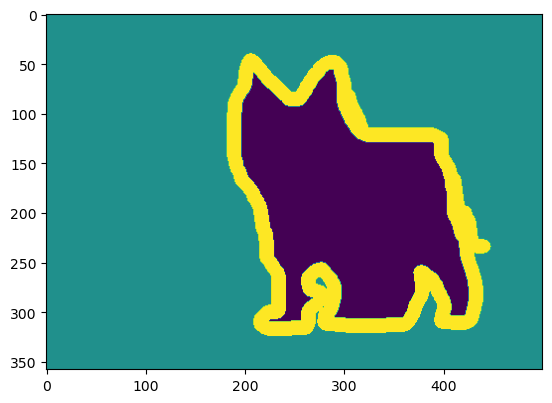

In [9]:
plt.imshow(image)

In [10]:
image.numpy().max()

3

In [11]:
image.numpy()

array([[2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       ...,
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2]], dtype=uint8)

In [12]:
np.unique(image.numpy())

array([1, 2, 3], dtype=uint8)

In [13]:
image.numpy().min()

1

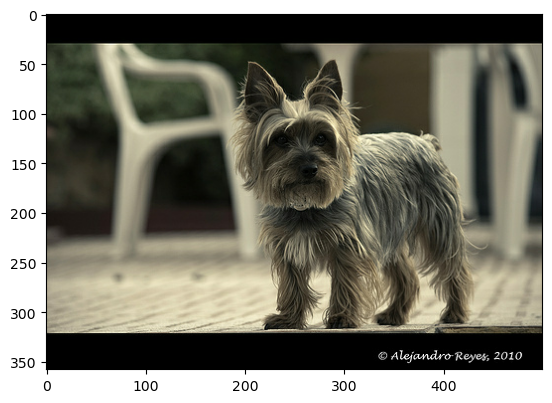

In [14]:
image = tf.io.read_file("./dataset/image_position_dataset/images/yorkshire_terrier_99.jpg")
image = tf.image.decode_jpeg(image)
plt.imshow(image)

In [15]:
images = glob.glob(r"./dataset/image_position_dataset/images/*.jpg")

In [16]:
images[:3]

['./dataset/image_position_dataset/images\\Abyssinian_1.jpg',
 './dataset/image_position_dataset/images\\Abyssinian_10.jpg',
 './dataset/image_position_dataset/images\\Abyssinian_100.jpg']

In [17]:
len(images)

7390

In [18]:
# 读取目标图像
label_images = glob.glob(r"./dataset/image_position_dataset/annotations/trimaps/*.png")

In [19]:
label_images[:3]

['./dataset/image_position_dataset/annotations/trimaps\\Abyssinian_1.png',
 './dataset/image_position_dataset/annotations/trimaps\\Abyssinian_10.png',
 './dataset/image_position_dataset/annotations/trimaps\\Abyssinian_100.png']

In [20]:
len(label_images)

7390

In [21]:
# 排序，保证顺序一致
images.sort(key=lambda x:x.split("\\")[-1].split(".jpg")[0])
label_images.sort(key=lambda x:x.split("\\")[-1].split(".png")[0])

In [22]:
# 做乱序处理，但images和label_images也是一样的
np.random.seed(2019)
index = np.random.permutation(len(images))

In [23]:
images = np.array(images)[index]
label_images = np.array(label_images)[index]

In [24]:
type(label_images)

numpy.ndarray

In [24]:
dataset = tf.data.Dataset.from_tensor_slices((images, label_images))

In [25]:
test_count = int(len(images)*0.2)
train_count = len(images)-test_count

In [26]:
test_count,train_count

(1478, 5912)

In [27]:
train_dataset = dataset.skip(test_count)
test_dataset = dataset.take(test_count)

In [28]:
def read_jpg(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image

In [29]:
def read_png(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=1)
    return image

In [30]:
def normal_image(input_image, input_label_image):
    input_image = tf.cast(input_image, tf.float32)
    input_image = input_image/127.5 - 1
    input_label_image = input_label_image - 1
    return input_image, input_label_image

In [31]:
@tf.function
def load_images(input_image_path, input_label_image_path):
    input_image = read_jpg(input_image_path)
    input_image = tf.image.resize(input_image, [224,224])
    input_label_image = read_png(input_label_image_path)
    input_label_image = tf.image.resize(input_label_image, [224,224])
    return normal_image(input_image,input_label_image)

In [32]:
train_dataset = train_dataset.map(load_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [33]:
test_dataset = test_dataset.map(load_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [34]:
train_dataset

<ParallelMapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(224, 224, 1), dtype=tf.float32, name=None))>

In [35]:
BATCH_SIZE = 8

In [36]:
# 乱序和设置每次取多少的问题
train_dataset = train_dataset.repeat().shuffle(100).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [37]:
train_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None))>

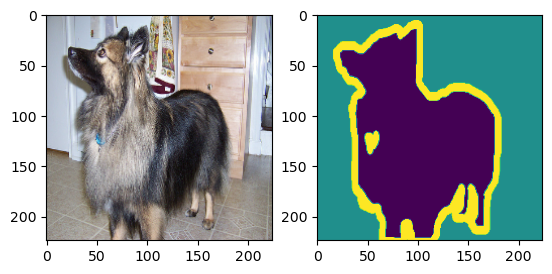

In [38]:
for image, label_image in train_dataset.take(1):
    plt.subplot(1,2,1)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(image[0]))
    plt.subplot(1,2,2)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(label_image[0]))

# 使用预训练网络

In [39]:
# 使用VGG16与训练网络
conv_base = tf.keras.applications.VGG16(
    weights="imagenet",
    input_shape=(224,224,3),
    include_top=False
)

In [40]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [41]:
# 拿到最后一层的输出做上采样，上采样：反卷积
# 7*7*512，反卷积：14*14*512
# 获取预训练网络的中间层: 切片，也可以是使用get_layer方法
conv_base.get_layer('block5_conv3').output

<KerasTensor: shape=(None, 14, 14, 512) dtype=float32 (created by layer 'block5_conv3')>

In [42]:
# 如何创建一个子的model： 函数式API
# 创建的子模型，会继承VGG16的预训练的权重
sub_model = tf.keras.models.Model(
    inputs=conv_base.input,
    outputs=conv_base.get_layer('block5_conv3').output
)

In [43]:
sub_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

# 如何获取中间层输出值

In [44]:
# 如何一次性获得多输出层
# 列表推导式
layer_names = [
    "block5_conv3",
    "block4_conv3",
    "block3_conv3",
    "block5_pool"
]

In [45]:
layers_output = [conv_base.get_layer(layer_name).output for layer_name in layer_names]

In [46]:
multi_out_model = tf.keras.models.Model(
    inputs=conv_base.input,
    outputs=layers_output
)

In [47]:
# 不允许训练
multi_out_model.trainable = False

# FCN模型创建

In [48]:
# 根据语义分割的模型创建自己需要的语义分割模型
# 模型输入
inputs = tf.keras.layers.Input(shape=(224,224,3))
output_block5_conv3,output_block4_conv3,output_block3_conv3,output_block5_pool = multi_out_model(inputs)

In [49]:
# 上采样
reverse_one = tf.keras.layers.Conv2DTranspose(
    512,
    3,
    strides=2,
    padding="same",
    activation="relu"
)(output_block5_pool)

In [50]:
reverse_one.shape

TensorShape([None, 14, 14, 512])

In [51]:
# 增加一层卷积提取特征
reverse_one = tf.keras.layers.Conv2D(512,3,padding="same",activation="relu")(reverse_one)

In [52]:
reverse_one.shape

TensorShape([None, 14, 14, 512])

In [53]:
reverse_two = tf.add(reverse_one,output_block5_conv3)

In [54]:
reverse_two = tf.keras.layers.Conv2DTranspose(
    512,
    3,
    strides=2,
    padding="same",
    activation="relu"
)(reverse_two)

In [55]:
reverse_two

<KerasTensor: shape=(None, 28, 28, 512) dtype=float32 (created by layer 'conv2d_transpose_1')>

In [56]:
reverse_two = tf.keras.layers.Conv2D(512,3,padding="same",activation="relu")(reverse_two)

In [57]:
reverse_two

<KerasTensor: shape=(None, 28, 28, 512) dtype=float32 (created by layer 'conv2d_1')>

In [58]:
reverse_three = tf.add(reverse_two,output_block4_conv3)

In [59]:
reverse_three

<KerasTensor: shape=(None, 28, 28, 512) dtype=float32 (created by layer 'tf.math.add_1')>

In [60]:
reverse_three = tf.keras.layers.Conv2DTranspose(
    256,
    3,
    strides=2,
    padding="same",
    activation="relu"
)(reverse_three)

In [61]:
reverse_three = tf.keras.layers.Conv2D(256,3,padding="same",activation="relu")(reverse_three)

In [62]:
reverse_three

<KerasTensor: shape=(None, 56, 56, 256) dtype=float32 (created by layer 'conv2d_2')>

In [63]:
reverse_four = tf.add(reverse_three,output_block3_conv3)

In [64]:
reverse_four.shape

TensorShape([None, 56, 56, 256])

In [65]:
reverse_four = tf.keras.layers.Conv2DTranspose(
    128,
    3,
    strides=2,
    padding="same",
    activation="relu"
)(reverse_four)

In [66]:
reverse_four.shape

TensorShape([None, 112, 112, 128])

In [67]:
reverse_four = tf.keras.layers.Conv2D(128,3,padding="same",activation="relu")(reverse_four)

In [68]:
reverse_four.shape

TensorShape([None, 112, 112, 128])

In [69]:
prediction = tf.keras.layers.Conv2DTranspose(
    3,
    3,
    strides=2,
    padding="same",
    activation="relu"
)(reverse_four)

In [70]:
prediction.shape

TensorShape([None, 224, 224, 3])

In [71]:
model = tf.keras.models.Model(
    inputs=inputs,
    outputs=prediction
)

In [72]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_1 (Functional)           [(None, 14, 14, 512  14714688    ['input_2[0][0]']                
                                ),                                                                
                                 (None, 28, 28, 512                                               
                                ),                                                                
                                 (None, 56, 56, 256                                         

In [73]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["acc"]
)

In [ ]:
history = model.fit(
    train_dataset,
    epochs=5,
    steps_per_epoch=train_count//BATCH_SIZE,
    validation_data=test_dataset,
    validation_steps=test_count//BATCH_SIZE
)

In [ ]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(5)
plt.figure()
plt.plot(epochs, loss, "r", label="Training loss")
plt.plot(epochs, loss, "r", label="Validation loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.ylim([0,1])
plt.legend()
plt.show()

In [ ]:
for image, mask in test_dataset.take(1):
    pred_mask = model.predict(image)
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[...,tf.newaxis]
    
    plt.figure(figsize=(10,10))
    for i in range(num):
        plt.subplot(num, 3, i*num+1)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(image[i]))
        plt.subplot(num, 3, i*num+2)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(mask[i]))
        plt.subplot(num, 3, i*num+3)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(pred_mask[i]))